<a href="https://colab.research.google.com/github/Monika171/Deep-Learning-with-Pytorch/blob/main/logisticregression_softmax_cross_entropy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1VyN8Yg3aG2aKY3Pj0unMSZ2WGK51aqgj')

     |████████████████████████████████| 71kB 3.1MB/s 


In [2]:
# !pip install jovian --upgrade --quiet

## Working with images

Image classification. 

We'll use the famous MNIST Handwritten Digits Database as our training dataset. It consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents.

We begin by installing and importing torch and torchvision. torchvision contains some utilities for working with image data. It also provides helper classes to download and import popular datasets like MNIST automatically

In [3]:
# imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [4]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


When this statement is executed for the first time, it downloads the data to the data/ directory next to the notebook and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded.

Not only downloded files but also converted into Pytorch dataset object

In [5]:
len(dataset)

60000

The dataset has 60,000 images that we'll use to train the model. There is also an additional test set of 10,000 images used for evaluating models and reporting metrics in papers and reports. We can create the **test dataset** using the `MNIST` class by passing `train=False` to the constructor.

In [6]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [7]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F43A87BFF28>, 5)

Part of Python Image Library, 

Also called Pillow.

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL`.Image.Image, which is a part of the Python imaging library Pillow. We can view the image within Jupyter using `matplotlib`, the de-facto plotting and graphing library for data science in Python.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


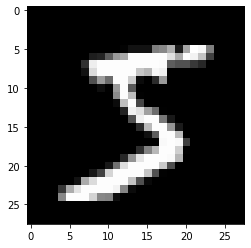

In [9]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


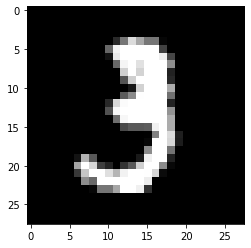

In [10]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [11]:
import torchvision.transforms as transforms 

In [12]:
# MNIST dataset (images and labels)
# convert these images into tensors as we load them
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [13]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [14]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with 0 representing black, 1 white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

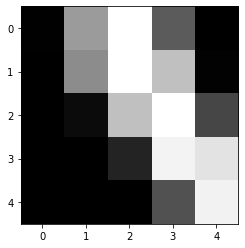

In [15]:
# Plot the image by passing in the 28 x 28 matrix
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray');

Note that we need to pass just the 28x28 matrix to plt.imshow, without a channel dimension. We also pass a color map (cmap=gray) to indicate that we want to see a grayscale image.

## Training and Validation Datasets
While building real-world machine learning models, it is quite common to split the dataset into three parts:

* Training set - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
* Validation set - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
*  Test set - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the random_spilt method from PyTorch.

In [16]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

It's essential to choose a random sample for creating a validation set. Training data is often sorted by the target labels, i.e., images of 0s, followed by 1s, followed by 2s, etc. If we create a validation set using the last 20% of images, it would only consist of 8s and 9s. In contrast, the training set would contain no 8s or 9s. Such a training-validation would make it impossible to train a useful model.

We can now create data loaders to help us load the data in batches. We'll use a batch size of 128.

In [17]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

We set shuffle=True for the training data loader to ensure that the batches generated in each epoch are different. This randomization helps generalize & speed up the training process. On the other hand, since the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

## Model
Now that we have prepared our data loaders, we can define our model.

* A logistic regression model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (pred = x @ w.t() + b).

* As we did with linear regression, we can use nn.Linear to create the model instead of manually creating and initializing the matrices.

* Since nn.Linear expects each training example to be a vector, each 1x28x28 image tensor is flattened into a vector of size 784 (28*28) before being passed into the model.

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability

In [18]:
import torch.nn as nn

input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Let's take a look at the weights and biases.

In [19]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[-0.0139,  0.0163,  0.0151,  ...,  0.0003, -0.0092, -0.0048],
        [-0.0214,  0.0227, -0.0263,  ...,  0.0345,  0.0322,  0.0106],
        [ 0.0057,  0.0327,  0.0353,  ...,  0.0266, -0.0071, -0.0299],
        ...,
        [ 0.0249,  0.0345,  0.0103,  ..., -0.0213, -0.0009, -0.0041],
        [-0.0179, -0.0029, -0.0100,  ...,  0.0188,  0.0104,  0.0075],
        [ 0.0297, -0.0044,  0.0333,  ..., -0.0016, -0.0156, -0.0124]],
       requires_grad=True)

In [21]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0184,  0.0254,  0.0197, -0.0088,  0.0083, -0.0161, -0.0171, -0.0249,
         0.0133, -0.0279], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [22]:
for images, labels in train_loader:
  print(labels)
  print(images.shape)
  outputs = model(images)
  print(outputs)
  break

tensor([4, 2, 8, 8, 7, 3, 6, 1, 3, 1, 9, 9, 9, 5, 5, 6, 5, 3, 3, 2, 7, 7, 4, 2,
        7, 8, 1, 2, 5, 1, 6, 3, 1, 2, 3, 4, 0, 7, 5, 7, 4, 8, 4, 1, 9, 3, 6, 4,
        5, 6, 2, 5, 2, 0, 7, 0, 0, 4, 2, 0, 3, 3, 5, 1, 5, 5, 1, 2, 3, 0, 4, 0,
        7, 0, 5, 7, 5, 7, 4, 1, 9, 6, 0, 9, 9, 5, 1, 3, 6, 2, 5, 0, 2, 1, 6, 1,
        2, 4, 4, 4, 5, 9, 9, 5, 4, 9, 5, 5, 5, 1, 8, 7, 6, 3, 1, 3, 5, 0, 8, 6,
        7, 8, 2, 1, 1, 4, 3, 2])
torch.Size([128, 1, 28, 28])


RuntimeError: ignored

In [23]:
images.shape

torch.Size([128, 1, 28, 28])

In [24]:
images.reshape(128, 784).shape

torch.Size([128, 784])

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the .reshape method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the nn.Module class from PyTorch.

 Let's extend the nn.Module class from PyTorch to define a custom model.

In [26]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

model = MnistModel()

Inside the __init__ constructor method, we instantiate the weights and biases using nn.Linear. And inside the forward method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into self.linear.

xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has .weight and .bias attributes (as they are now inside the .linear attribute), but it does have a .parameters method that returns a list containing the weights and bias.

In [27]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [28]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0117,  0.0139,  0.0107,  ..., -0.0334,  0.0175,  0.0240],
         [ 0.0004, -0.0027,  0.0061,  ...,  0.0092,  0.0163, -0.0176],
         [ 0.0086,  0.0040,  0.0177,  ..., -0.0262,  0.0185, -0.0002],
         ...,
         [-0.0038, -0.0334, -0.0268,  ...,  0.0187,  0.0191, -0.0007],
         [-0.0192, -0.0198, -0.0147,  ..., -0.0347, -0.0091, -0.0305],
         [-0.0322,  0.0249, -0.0059,  ..., -0.0205,  0.0309, -0.0350]],
        requires_grad=True), Parameter containing:
 tensor([-0.0198, -0.0046,  0.0141,  0.0048,  0.0081, -0.0284,  0.0080,  0.0109,
         -0.0101,  0.0050], requires_grad=True)]

We can use our new custom model in the same way as before. Let's see if it works.

In [29]:
for images, labels in train_loader:
  print(images.shape)
  outputs = model(images)
  break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1210,  0.0776, -0.0137,  0.1398,  0.1073, -0.0671,  0.1016,  0.2038,
         -0.1519, -0.0472],
        [ 0.3091,  0.2275, -0.1310, -0.1659,  0.0260, -0.0381,  0.2854, -0.1316,
          0.0860, -0.0825]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function,

Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function, we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [30]:
import torch.nn.functional as F

The softmax function is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be applied.

In [31]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum:", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0860, 0.1049, 0.0958, 0.1117, 0.1081, 0.0908, 0.1075, 0.1191, 0.0834,
         0.0926],
        [0.1291, 0.1190, 0.0832, 0.0803, 0.0973, 0.0913, 0.1261, 0.0831, 0.1033,
         0.0873]])
Sum: 0.9999998807907104


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using torch.max, which returns each row's largest element and the corresponding index.

In [32]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([7, 0, 1, 4, 6, 6, 9, 9, 3, 4, 2, 1, 3, 1, 1, 6, 1, 3, 1, 9, 1, 9, 6, 6,
        1, 6, 9, 1, 6, 9, 4, 7, 6, 9, 8, 7, 6, 6, 9, 6, 6, 7, 6, 8, 3, 9, 6, 6,
        6, 6, 6, 6, 6, 6, 3, 1, 9, 6, 6, 6, 6, 1, 3, 3, 1, 9, 3, 6, 9, 1, 4, 1,
        6, 6, 1, 2, 9, 1, 0, 1, 7, 6, 3, 1, 7, 6, 8, 0, 5, 6, 4, 4, 6, 0, 4, 8,
        5, 9, 9, 9, 3, 2, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 2, 3, 6, 1, 6, 1, 9, 1,
        9, 6, 9, 2, 1, 7, 1, 7])
tensor([0.1191, 0.1291, 0.1231, 0.1157, 0.1412, 0.1526, 0.1161, 0.1297, 0.1197,
        0.1321, 0.1219, 0.1313, 0.1092, 0.1324, 0.1313, 0.1369, 0.1272, 0.1365,
        0.1251, 0.1166, 0.1305, 0.1207, 0.1301, 0.1229, 0.1212, 0.1144, 0.1310,
        0.1206, 0.1461, 0.1173, 0.1164, 0.1163, 0.1322, 0.1145, 0.1236, 0.1280,
        0.1363, 0.1309, 0.1163, 0.1294, 0.1172, 0.1261, 0.1385, 0.1275, 0.1270,
        0.1261, 0.1376, 0.1373, 0.1247, 0.1621, 0.1654, 0.1290, 0.1453, 0.1143,
        0.1366, 0.1224, 0.1306, 0.1392, 0.1500, 0.1147, 0.1309, 0.1402, 0.1156,
       

The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [33]:
labels

tensor([8, 5, 8, 2, 6, 2, 6, 3, 6, 0, 6, 7, 3, 8, 0, 8, 4, 8, 2, 3, 9, 9, 8, 8,
        8, 5, 4, 4, 6, 1, 0, 6, 4, 1, 5, 3, 6, 1, 4, 9, 9, 4, 2, 3, 1, 0, 7, 0,
        9, 2, 6, 6, 1, 8, 2, 4, 2, 4, 2, 4, 2, 0, 1, 5, 0, 9, 5, 2, 5, 5, 0, 5,
        1, 2, 5, 7, 9, 3, 2, 0, 3, 3, 2, 7, 1, 8, 2, 5, 5, 1, 1, 0, 9, 5, 1, 3,
        5, 5, 1, 5, 9, 5, 7, 9, 7, 6, 5, 5, 9, 7, 2, 8, 6, 5, 9, 4, 6, 8, 2, 6,
        3, 7, 7, 7, 6, 1, 4, 7])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the accuracy of the predictions.

In [34]:
outputs[:2]

tensor([[-0.1210,  0.0776, -0.0137,  0.1398,  0.1073, -0.0671,  0.1016,  0.2038,
         -0.1519, -0.0472],
        [ 0.3091,  0.2275, -0.1310, -0.1659,  0.0260, -0.0381,  0.2854, -0.1316,
          0.0860, -0.0825]], grad_fn=<SliceBackward>)

In [35]:
torch.sum(preds == labels)

tensor(15)

In [36]:
def accuracy(output, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `True` for unequal elements and `False` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

In [37]:
# Let's calculate the accuracy of the current model on the first batch of data.

accuracy(outputs, labels)

tensor(0.1172)

In [38]:
probs

tensor([[0.0860, 0.1049, 0.0958,  ..., 0.1191, 0.0834, 0.0926],
        [0.1291, 0.1190, 0.0832,  ..., 0.0831, 0.1033, 0.0873],
        [0.1188, 0.1231, 0.1211,  ..., 0.0588, 0.1120, 0.0972],
        ...,
        [0.0998, 0.0971, 0.0937,  ..., 0.1230, 0.0928, 0.1014],
        [0.0961, 0.1289, 0.1079,  ..., 0.0811, 0.0997, 0.1200],
        [0.0848, 0.1257, 0.1094,  ..., 0.1277, 0.0791, 0.1036]],
       grad_fn=<SoftmaxBackward>)

In [39]:
outputs

tensor([[-0.1210,  0.0776, -0.0137,  ...,  0.2038, -0.1519, -0.0472],
        [ 0.3091,  0.2275, -0.1310,  ..., -0.1316,  0.0860, -0.0825],
        [ 0.0451,  0.0804,  0.0642,  ..., -0.6591, -0.0142, -0.1560],
        ...,
        [ 0.0221, -0.0061, -0.0414,  ...,  0.2306, -0.0513,  0.0378],
        [-0.0039,  0.2898,  0.1117,  ..., -0.1740,  0.0326,  0.2180],
        [-0.1362,  0.2570,  0.1187,  ...,  0.2727, -0.2065,  0.0636]],
       grad_fn=<AddmmBackward>)

In [40]:
loss_fn = F.cross_entropy

In [41]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3108, grad_fn=<NllLossBackward>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. 2.23 is look at e^-2.23 which is around 0.1 as the predicted probability of the correct label, on average. The lower the loss, The better the model.

##Training the model
Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection

```
# This is formatted as code
```


Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called fit, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the nn.Module class.

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.

In [42]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = [] # for recording epoch-wise results

  # Training Phase
  for epoch in range(epochs):
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation phase
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

The `fit` function records the validation loss and metric from each epoch. It returns a history of the training, useful for debugging & visualization.

Configurations like batch size, learning rate, etc. (called hyperparameters), need to picked in advance while training machine learning models. Choosing the right hyperparameters is critical for training a reasonably accurate model within a reasonable amount of time. It is an active area of research and experimentation in machine learning. Feel free to try different learning rates and see how it affects the training process.

Let's define the `evaluate` function, used in the validation phase of `fit`.

In [43]:
l1 = [1, 2, 3, 4, 5]

In [44]:
l2 = [x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [45]:
jovian.commit(project='logistic-regression-softmax-crossentropy')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/monika171/logistic-regression-softmax-crossentropy


'https://jovian.ai/monika171/logistic-regression-softmax-crossentropy'